In [1]:
# Might need to install some extra dependencies first to run this:
# !pip install --user vega seaborn
# !jupyter nbextension install --user --py vega3
# !jupyter nbextension enable vega3 --user --py

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 150

In [4]:
# These functions will soon move into fast-manipulator / fast-plotter
import re
import os
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype

# Interpret the filename
def get_read_options(filename):
    decipher = re.compile(r"tbl_(?P<index>.*?)(|--(?P<weights>.*))\.csv")
    groups = decipher.match(os.path.basename(filename))
    
    index_cols = groups.group("index").split(".")
    options = dict(index_col = range(len(index_cols)),
                   comment = "#"
                   )
    return options
    
def read_binned_df(filename):
    return pd.read_csv(filename, **get_read_options(filename))

def split_df(df, first_values, level=0):
    second = df.drop(first_values, level=level)
    second_values = second.index.unique(level=level)
    first = df.drop(second_values, level=level)
    return first, second

def split_data_sims(df, data_labels=["data"], dataset_level="dataset"):
    return split_df(df, first_values=data_labels, level=dataset_level)

def calculate_error(df, sumw2_label="sumw2", err_label="err", inplace=True):
    if not inplace:
        df = df.copy()
    for column in df:
        if sumw2_label in column:
            err_name = column.replace(sumw2_label, err_label)
            df[err_name] = np.sqrt(df[column])
    if not inplace:
        return df

def stack_sims(df, data_labels=["data"], dataset_level="dataset"):
    data, sims = split_data_sims(df, data_labels=data_labels, dataset_level=dataset_level)
    dataset_level_no = sims.index.names.index(dataset_level)
    group_levels = range(sims.index.nlevels)
    group_levels.remove(dataset_level_no)
    sim_stacked = sims.groupby(level=group_levels).cumsum()
    return data.append(sim_stacked)


_interval_regex = r"^(?P<open>[[(])"
_interval_regex += r"(?P<low>-inf|[0-9][.0-9]*)"
_interval_regex += r"\s*,\s*"
_interval_regex += r"(?P<high>\+?inf|[0-9][.0-9]*)"
_interval_regex += r"(?P<close>[)\]])$"


def interval_from_string(series):
    if not is_string_dtype(series):
        return series
    extracted = series.str.extract(_interval_regex)
    extracted = extracted.dropna()
    if len(extracted) != len(series):
        return series
    left_closed = extracted.open.unique()
    right_closed = extracted.close.unique()
    if len(right_closed) != 1 or len(right_closed) != 1:
        return series
    left_closed = left_closed[0] == "["
    right_closed = right_closed[0] == "]"
    if left_closed:
        if right_closed:
            closed = "both"
        else:
            closed = "left"
    else:
        if right_closed:
            closed = "right"
        else:
            closed = "neither"
    interval = pd.IntervalIndex.from_arrays(left=pd.to_numeric(extracted.low), 
                                            right=pd.to_numeric(extracted.high), 
                                            closed=closed)
    return interval

## Load in the data

In [5]:
!column -s, -t "example_outputs/tbl_dataset.nMuons.nIsoMuons--weighted.csv" |head

dataset     nMuons  nIsoMuons  n         weighted:sumw           weighted:sumw2
data        0       0          227265.0                          
data        1       0          17795.0                           
data        1       1          205616.0                          
data        2       0          107.0                             
data        2       1          2393.0                            
data        2       2          16207.0                           
data        3       3          1.0                               
dy          0       0          2181.0    787.2786254882812       553.8453979492188
dy          1       0          2472.0    910.0523681640625       678.6613159179688


In [6]:
muons = read_binned_df("example_outputs/tbl_dataset.nMuons.nIsoMuons--weighted.csv")
muons.head(10)

n  weighted:sumw  weighted:sumw2
dataset nMuons nIsoMuons                                         
data    0      0          227265.0            NaN             NaN
        1      0           17795.0            NaN             NaN
               1          205616.0            NaN             NaN
        2      0             107.0            NaN             NaN
               1            2393.0            NaN             NaN
               2           16207.0            NaN             NaN
        3      3               1.0            NaN             NaN
dy      0      0            2181.0     787.278625      553.845398
        1      0            2472.0     910.052368      678.661316
               1           29027.0   13163.787109     9294.289062

## Project 2D to 1D vs datasets

In [7]:
muons_1d = muons.groupby(level=("dataset", "nMuons")).sum()
muons_1d.head(8)

n  weighted:sumw  weighted:sumw2
dataset nMuons                                         
data    0       227265.0       0.000000        0.000000
        1       223411.0       0.000000        0.000000
        2        18707.0       0.000000        0.000000
        3            1.0       0.000000        0.000000
dy      0         2181.0     787.278625      553.845398
        1        31499.0   14073.839478     9972.950378
        2        44048.0   19253.873589    10659.372234
        3            1.0       0.518289        0.268624

In [8]:
muons_1d = calculate_error(muons_1d, inplace=False)
muons_1d.head(8)

n  weighted:sumw  weighted:sumw2  weighted:err
dataset nMuons                                                       
data    0       227265.0       0.000000        0.000000      0.000000
        1       223411.0       0.000000        0.000000      0.000000
        2        18707.0       0.000000        0.000000      0.000000
        3            1.0       0.000000        0.000000      0.000000
dy      0         2181.0     787.278625      553.845398     23.533920
        1        31499.0   14073.839478     9972.950378     99.864660
        2        44048.0   19253.873589    10659.372234    103.244236
        3            1.0       0.518289        0.268624      0.518289

## Plotting 1D Data vs MC using Vega-lite
Plot things using Vega-lite:  
* Not a complete solution yet, eg: errorbars not working in notebook, etc, but is a way to go for the future
* Advantages: Reproducibility, interactivity

In [9]:
# Stack the values from MC; Vega-lite should be able to do this, but I've had problems...
stacked_df = stack_sims(muons_1d)

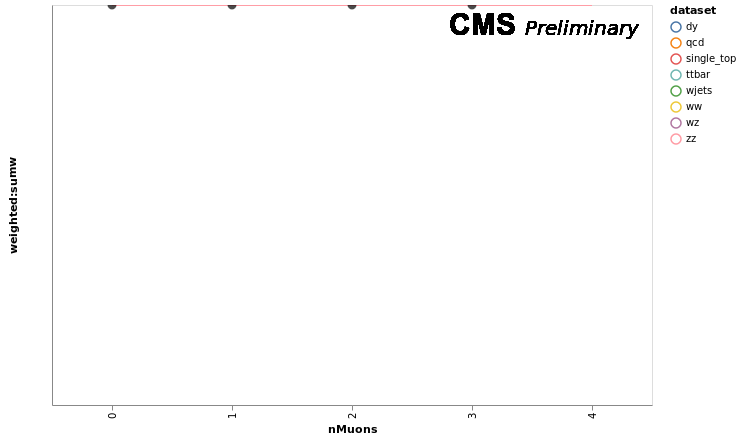

In [10]:
spec = {
   '$schema': 'https://vega.github.io/schema/vega-lite/v2.json',
   'config': {},
   'width': 600,
   'height': 400,
   'layer': [{
       "selection": {"grid": {"type": "interval", "bind": "scales"}},
       "mark": {"type": "line", "interpolate": "step","tooltip": {"field": ""}},
       "encoding": {
           "y": {
               "field": "weighted:sumw",
               "type": "quantitative", 
               "scale": {"type": "log", "domain": [0.01]}
           },
           "tooltip": [{"field": "weighted:sumw"}, {"field": "weighted:err"}],
           "color": {"field": "dataset", "type": "nominal"}
       },
       "transform": [{"filter": "datum.dataset != 'data'"}]
   },{
       "mark": {"type": "point", "filled": "true", "size": 80, "color": "black"},
       "encoding": {
           "y": {"field": "weighted:sumw","type": "quantitative"},
           "tooltip": [{"field": "weighted:sumw"}, {"field": "weighted:err"}]
       },
       "transform": [{"filter": "datum.dataset == 'data'"}]
   },{
       "mark": {"type": "text", "text": "CMS", "size": 30, "font": "Arial", "fontWeight": "bold"},
       "encoding": {"x": {"value": 430}, "y": {"value": 30}}
   },{
       "mark": {"type": "text", "text": "Preliminary", "size": 20, "fontStyle": "italic", "fontWeight": 5},
       "encoding": {"x": {"value": 530}, "y": {"value": 30}}
   }
   ],
    'encoding': {
        "x": {"field": "nMuons", "type": "ordinal", "grid": "true"}
    }
}
from vega import VegaLite
plot = VegaLite(spec, stacked_df.reset_index())
plot

## Plotting 1D Data vs MC using Matplotlib and built-in pandas

In [11]:
mu_data, mu_sims = split_data_sims(muons_1d)
mu_data

n  weighted:sumw  weighted:sumw2  weighted:err
dataset nMuons                                                       
data    0       227265.0            0.0             0.0           0.0
        1       223411.0            0.0             0.0           0.0
        2        18707.0            0.0             0.0           0.0
        3            1.0            0.0             0.0           0.0

In [12]:
mu_sims.head()

n  weighted:sumw  weighted:sumw2  weighted:err
dataset nMuons                                                      
dy      0        2181.0     787.278625    5.538454e+02     23.533920
        1       31499.0   14073.839478    9.972950e+03     99.864660
        2       44048.0   19253.873589    1.065937e+04    103.244236
        3           1.0       0.518289    2.686235e-01      0.518289
qcd     0         124.0   18058.283203    2.539280e+07   5039.127107

Text(0.64,0.932,'Preliminary')

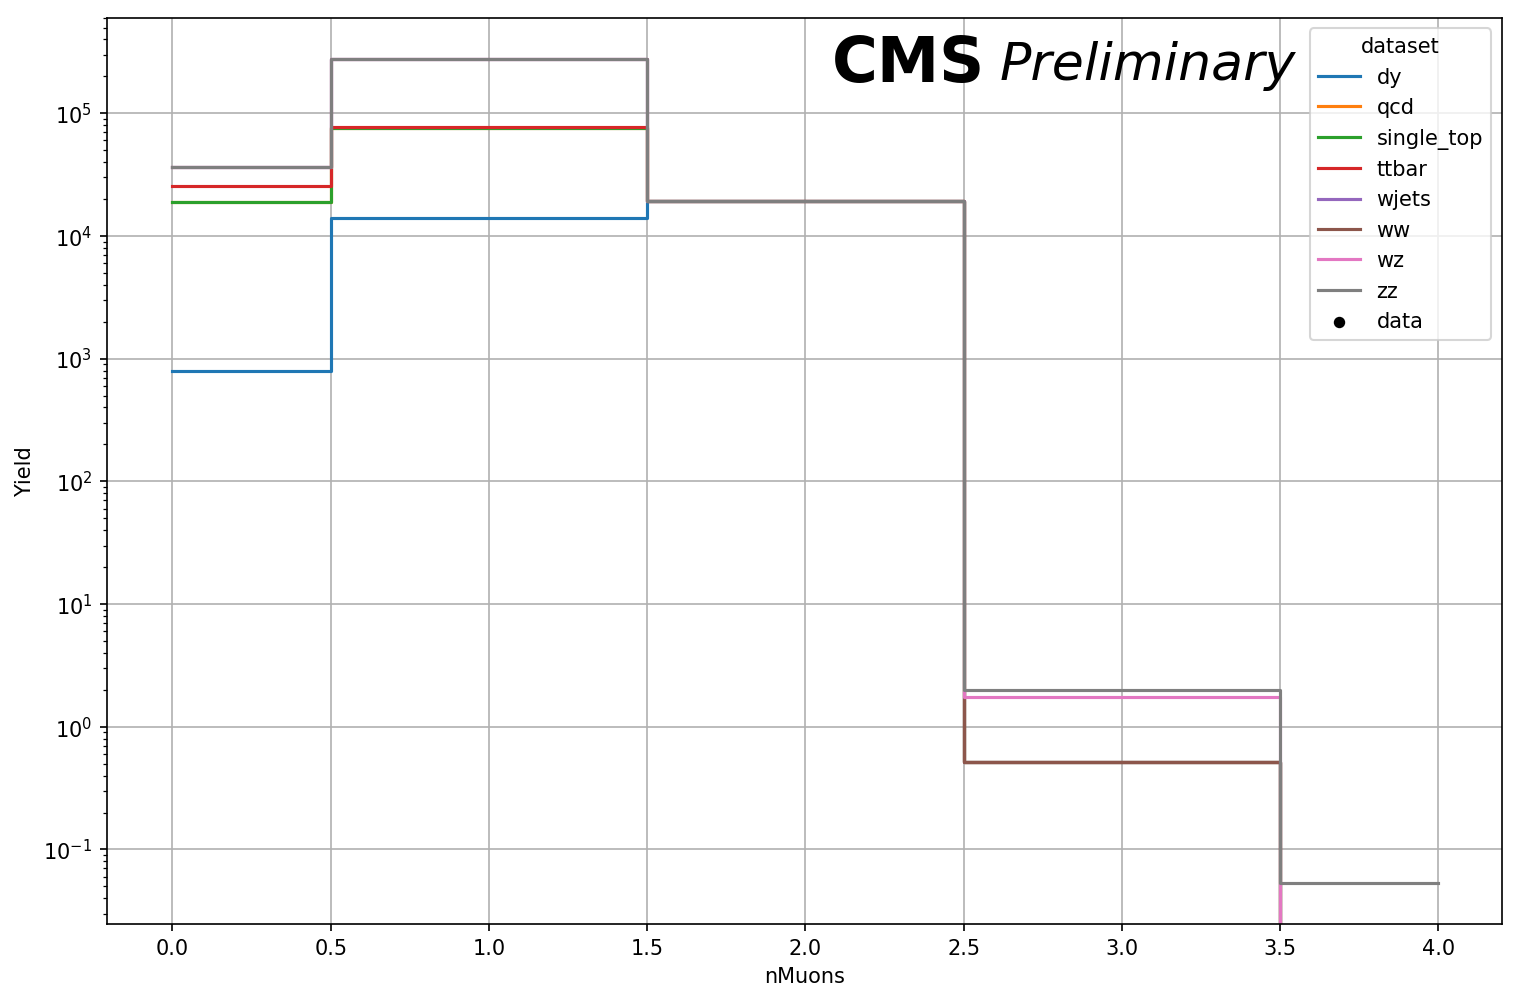

In [13]:
ax = plt.subplot(111)

mu_sims["weighted:sumw"].unstack(0).plot.line(drawstyle="steps-mid", logy=True, stacked=True, figsize=(12, 8), ax=ax)
mu_data.reset_index().plot.scatter(x="nMuons", y="weighted:sumw", yerr="weighted:err", color="k", label="data", ax=ax)

plt.grid(True)
plt.ylabel("Yield")
plt.annotate("CMS", (0.52, 0.93), xycoords="axes fraction",fontsize=30, fontweight="bold")
plt.annotate("Preliminary", (0.64, 0.932), xycoords="axes fraction",fontsize=25, fontstyle="italic")

## 2D heat-map plots

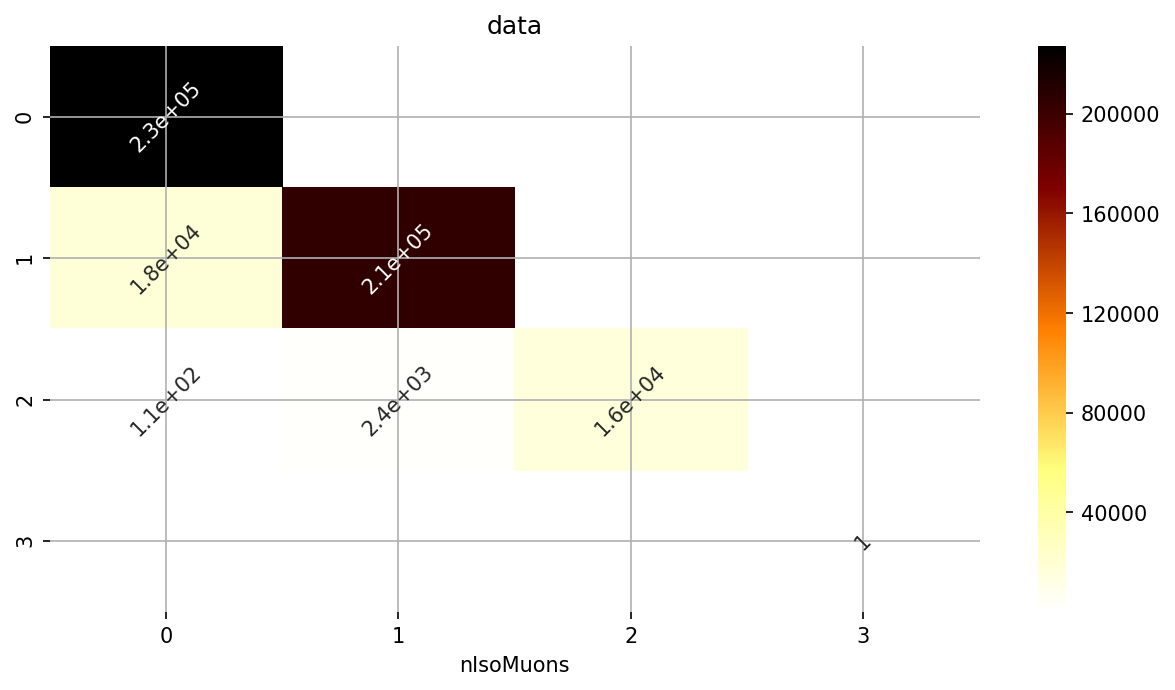

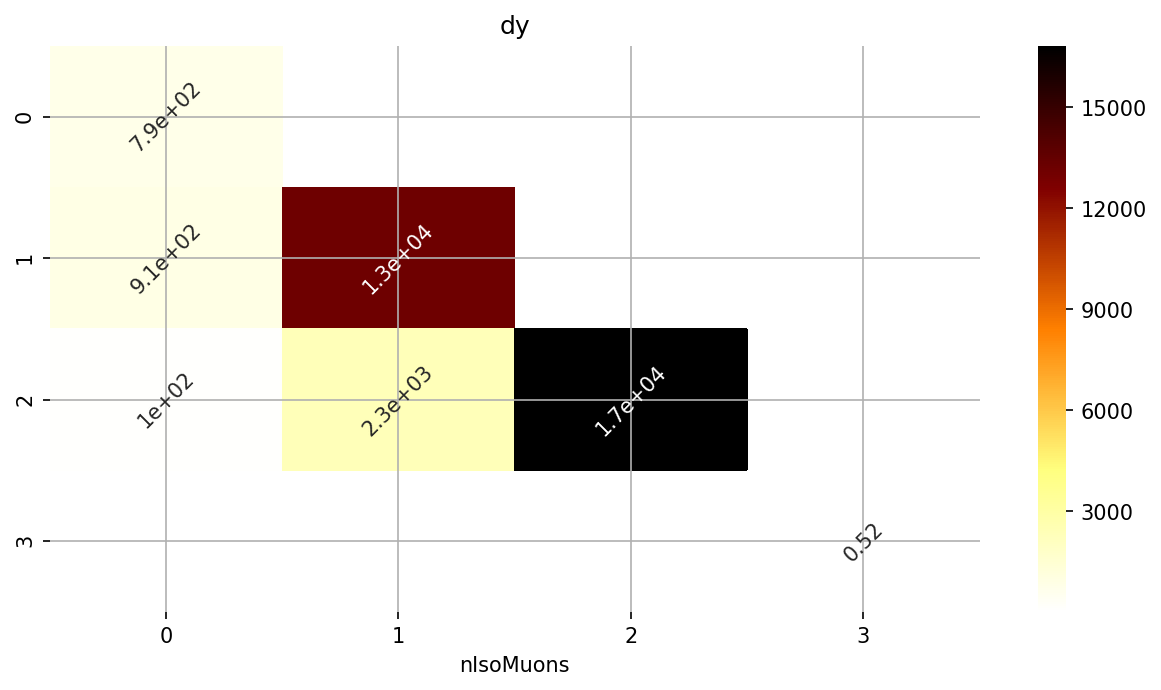

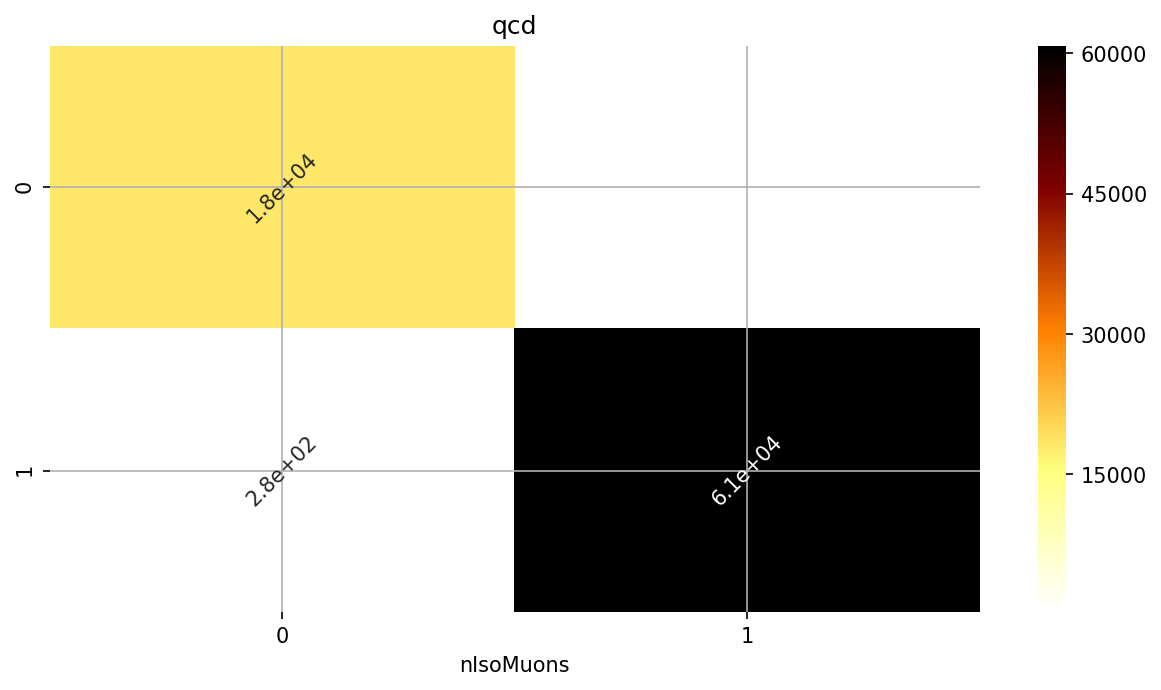

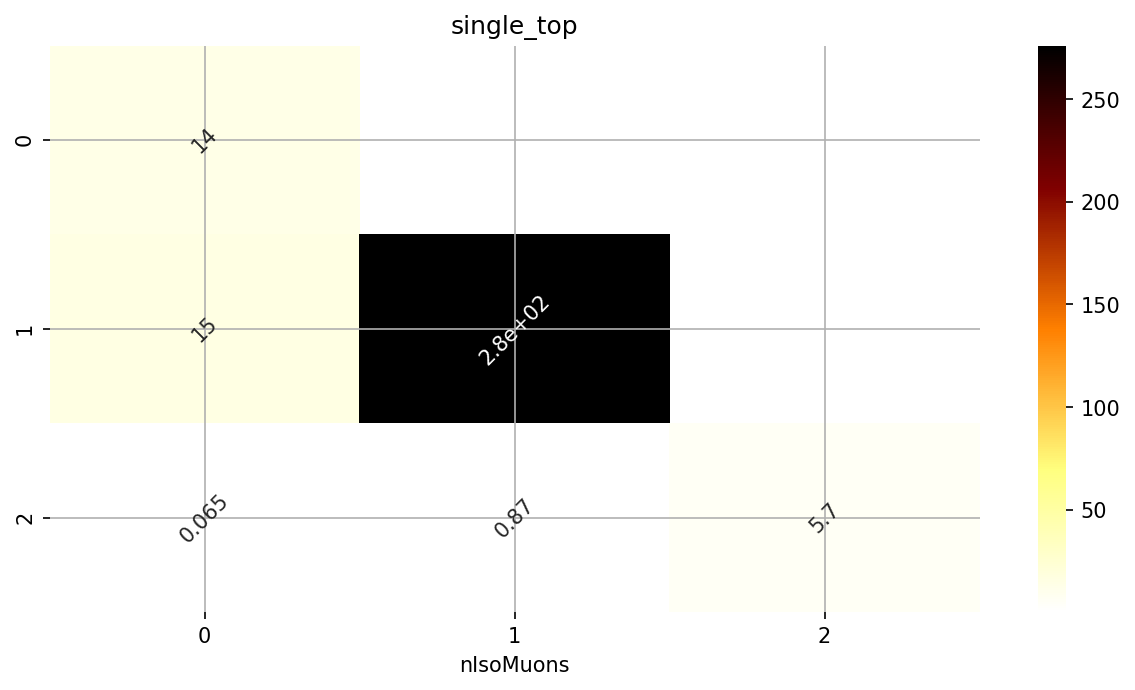

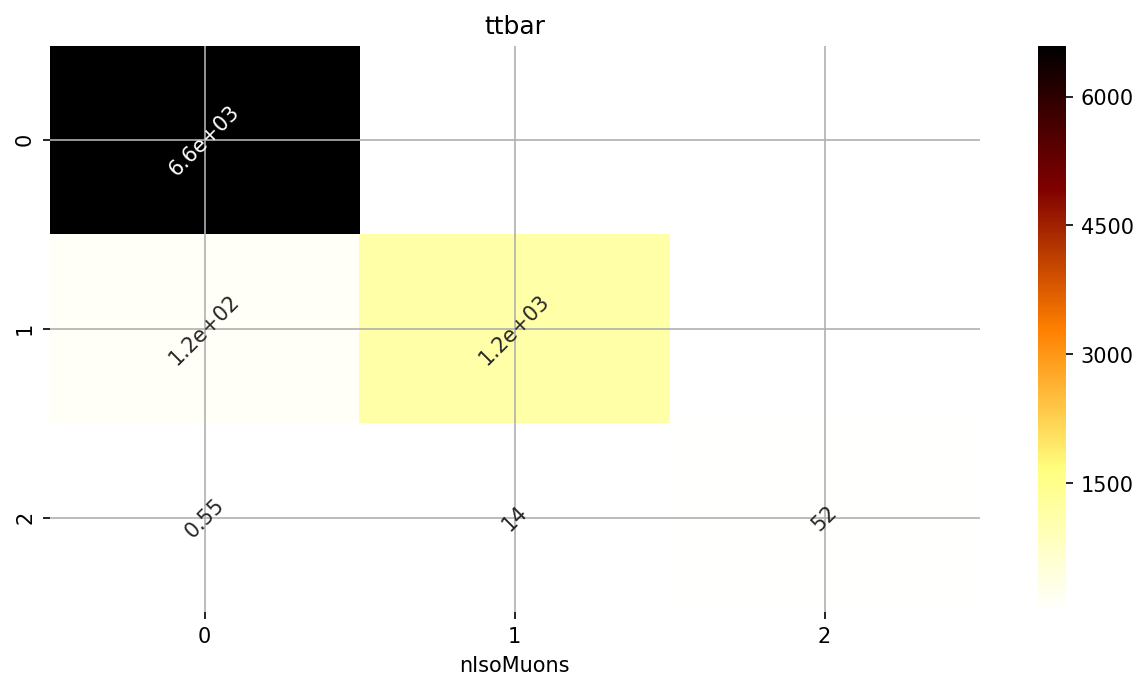

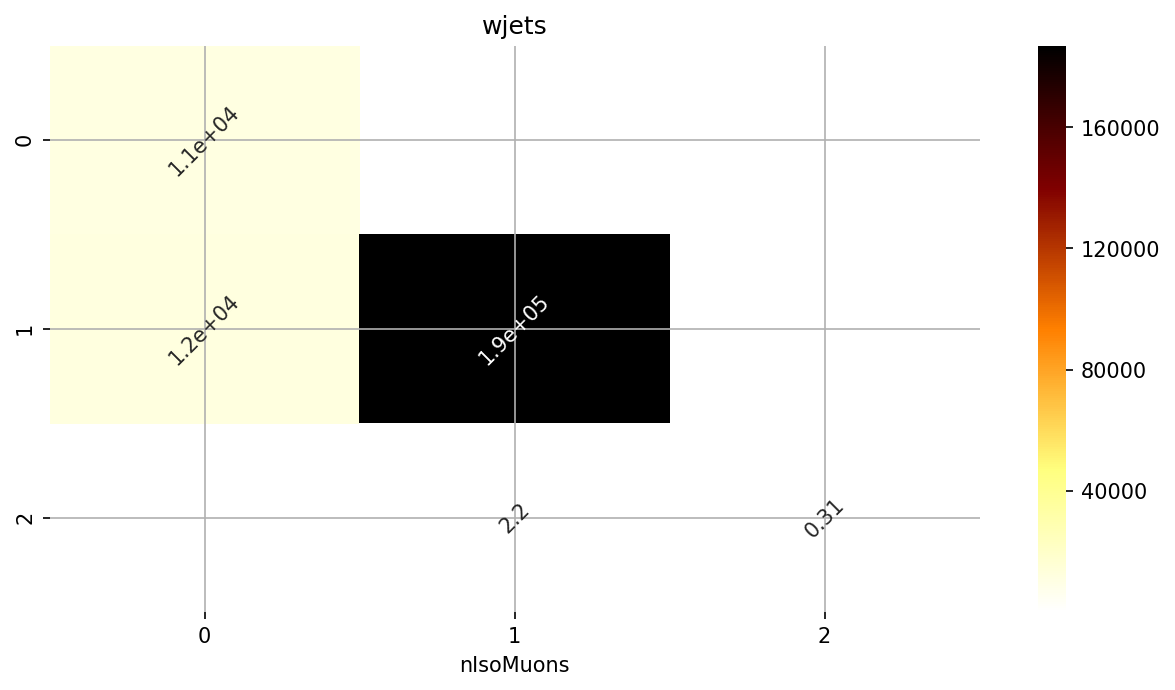

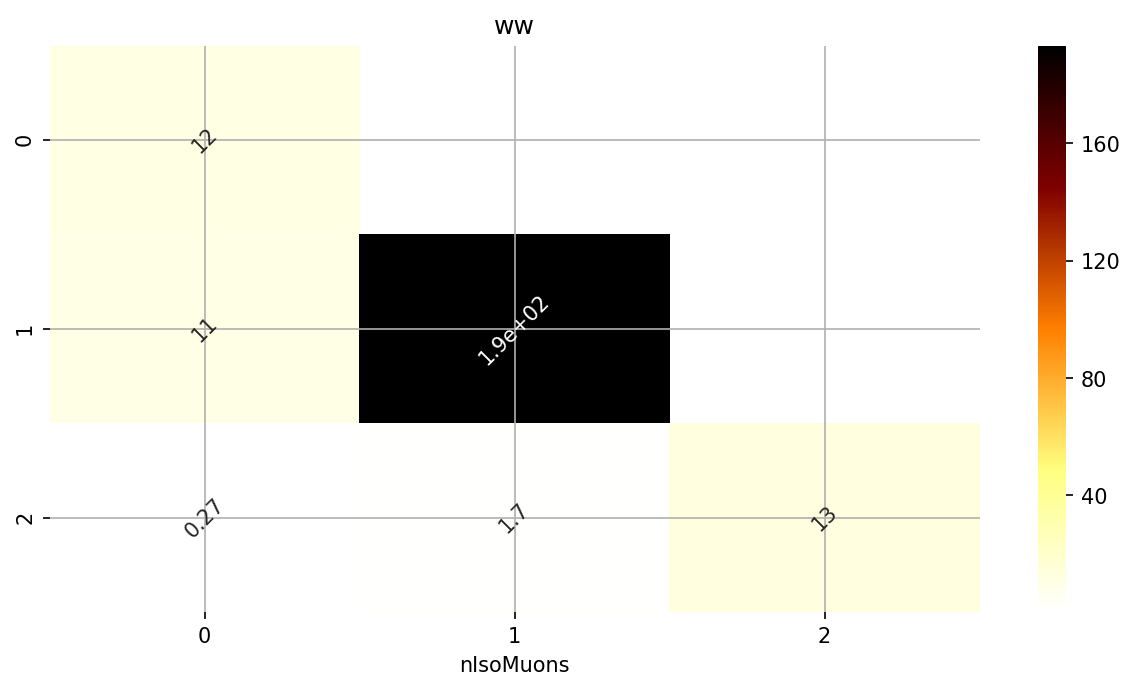

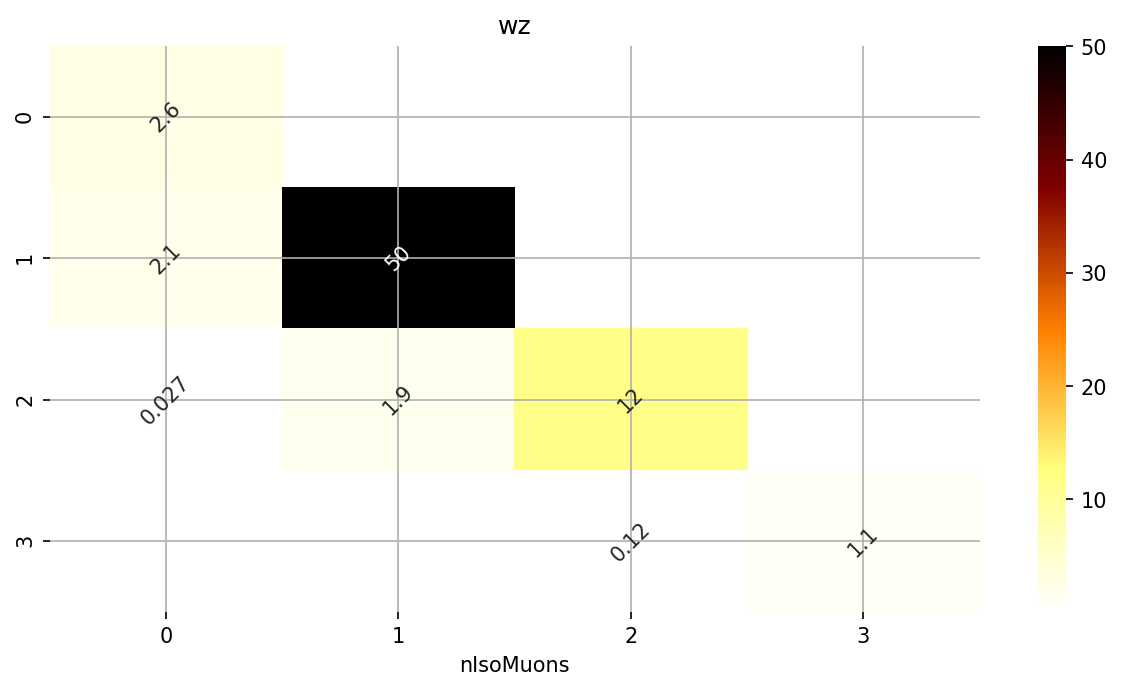

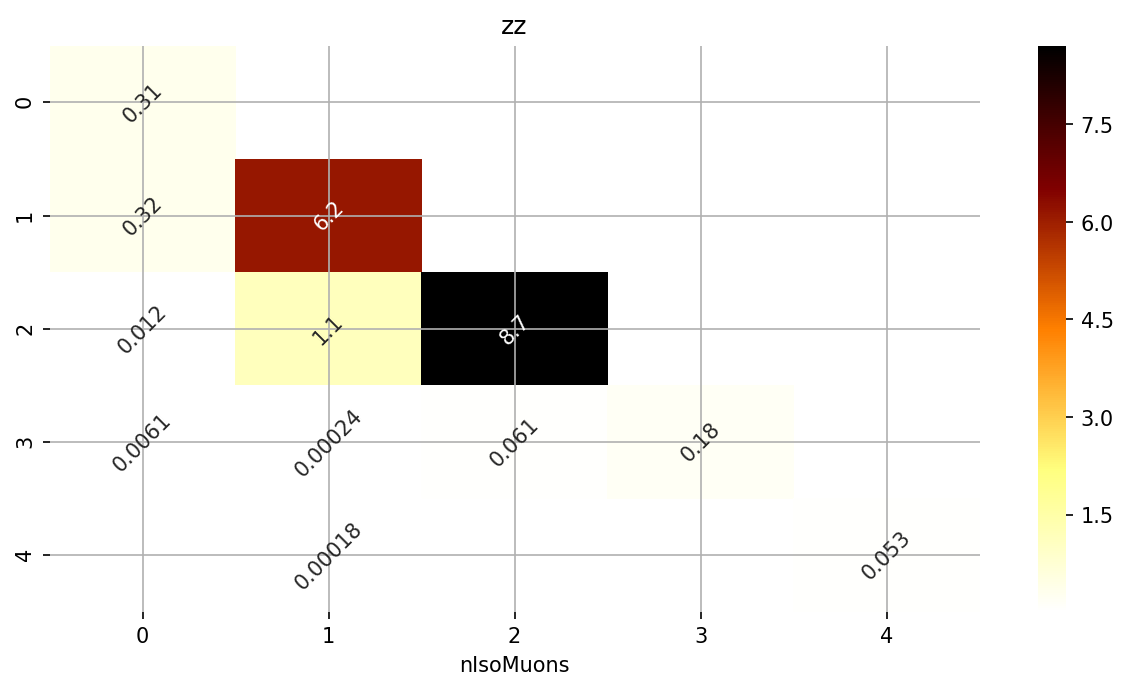

In [14]:
import seaborn as sns

values = "weighted:sumw"
y = "nMuons"
x = "nIsoMuons"
dataframe = muons.fillna(method="ffill", axis="columns").reset_index()
for dataset, group in dataframe.groupby("dataset"):
    df = group.pivot(index=y, columns=x, values=values)
    df = df.reset_index(0, drop=True)
                                      
    plt.figure(figsize=(10, 5))
    plt.title(dataset)
    sns.heatmap(df, cmap="afmhot_r",annot=True, annot_kws={"rotation": 45})
    plt.grid()

## Plot the Dimuon data
Uses an "interval index"

In [15]:
dimuon = read_binned_df("example_outputs/tbl_dataset.dimu_mass--weighted.csv")
dimuon.head()

n  weighted:sumw  weighted:sumw2
dataset dimu_mass                                         
data    (-inf, 60.0]  993.0            NaN             NaN
        (60.0, 61.0]   38.0            NaN             NaN
        (61.0, 62.0]   25.0            NaN             NaN
        (62.0, 63.0]   22.0            NaN             NaN
        (63.0, 64.0]   28.0            NaN             NaN

In [16]:
intervals = interval_from_string(dimuon.index.levels[1])
intervals

IntervalIndex([(-inf, 60.0], (100.0, 101.0], (101.0, 102.0], (102.0, 103.0], (103.0, 104.0] ... (95.0, 96.0], (96.0, 97.0], (97.0, 98.0], (98.0, 99.0], (99.0, 100.0]]
              closed='right',
              dtype='interval[float64]')

In [40]:
dimuon.index.set_levels(intervals.mid, level=1, inplace=True)
dimuon.iloc[range(5) + range(-5, 0)]

n  weighted:sumw  weighted:sumw2  weighted:err
dataset    dimu_mass                                                      
data       -inf         993.0     993.000000      993.000000     31.511903
            60.500000    38.0      38.000000       38.000000      6.164414
            61.500000    25.0      25.000000       25.000000      5.000000
            62.500000    22.0      22.000000       22.000000      4.690416
            63.500000    28.0      28.000000       28.000000      5.291503
single_top  116.500000    0.0       0.000000        0.000000      0.000000
            117.500000    0.0       0.000000        0.000000      0.000000
            118.500000    2.0       0.106012        0.005911      0.076883
            119.500000    1.0       0.065083        0.004236      0.065083
            inf          40.0       2.072110        0.118708      0.344540

(0.7, 10000.0)

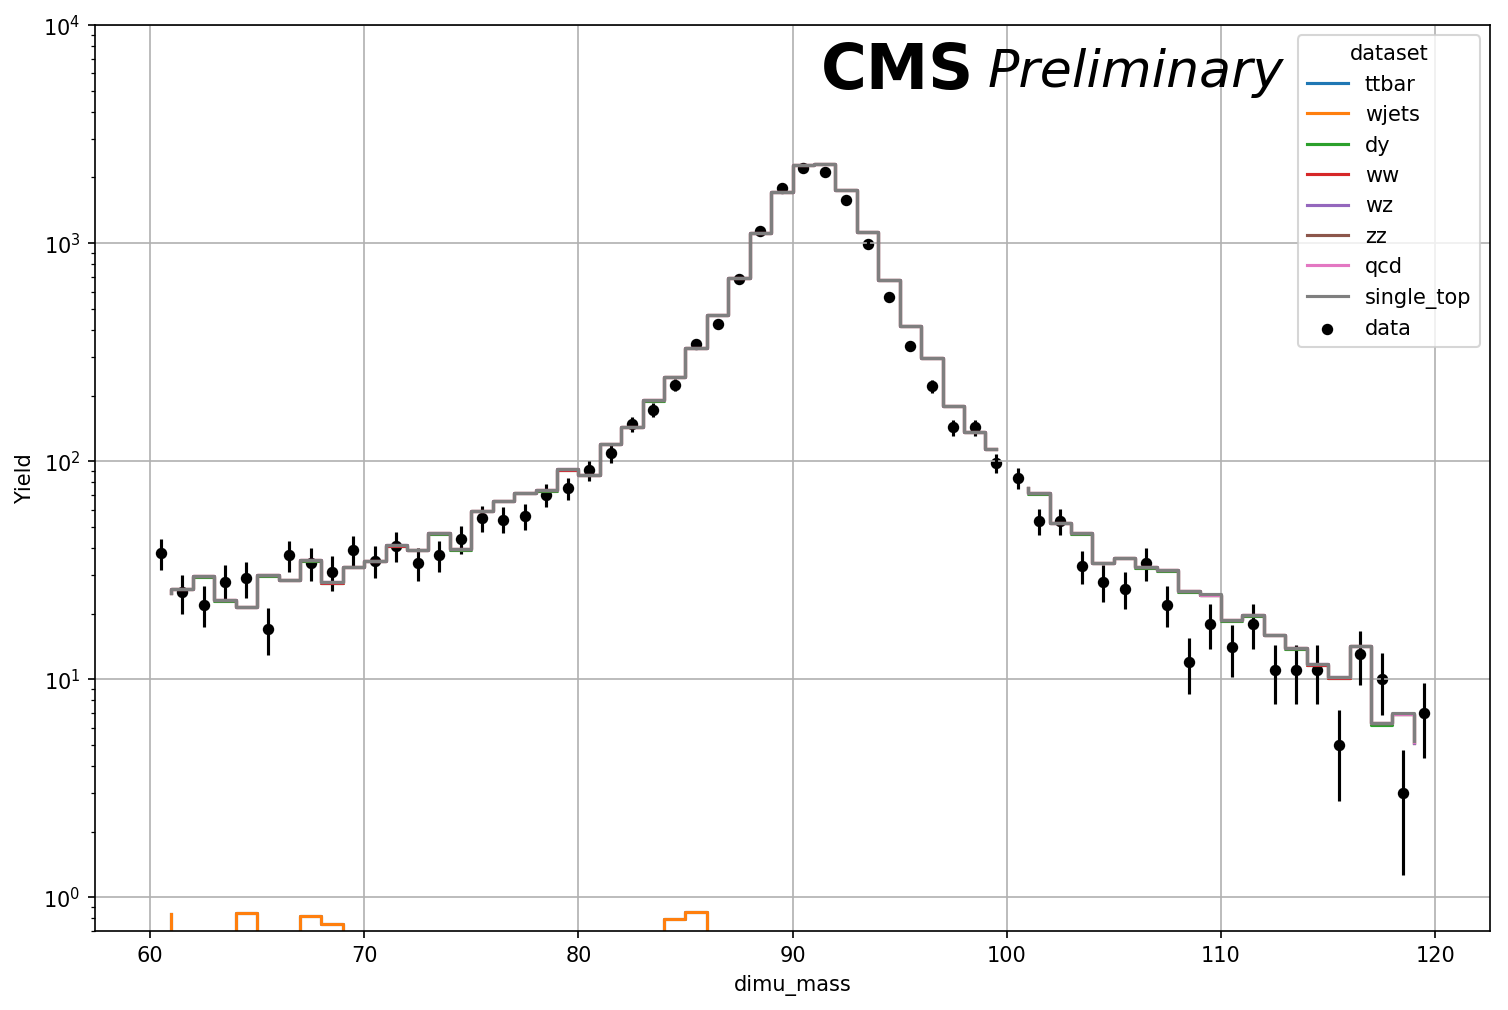

In [32]:
order = ["data", "ttbar", "wjets", "dy", "ww", "wz", "zz", "qcd", "single_top"]
dimuon = dimuon.reindex(order, axis=0, level=0).fillna(method="ffill", axis="columns")

calculate_error(dimuon, inplace=True)
dimu_data, dimu_sims = split_data_sims(dimuon)
ax = plt.subplot(111)

dimu_sims["weighted:sumw"].unstack(0).plot.line(drawstyle="steps-mid", logy=True, stacked=True, figsize=(12, 8), ax=ax)
dimu_data.reset_index().plot.scatter(x="dimu_mass", y="n", yerr="weighted:err", color="k", label="data", ax=ax)

plt.grid(True)
plt.ylabel("Yield")
plt.annotate("CMS", (0.52, 0.93), xycoords="axes fraction",fontsize=30, fontweight="bold")
plt.annotate("Preliminary", (0.64, 0.932), xycoords="axes fraction",fontsize=25, fontstyle="italic")
plt.ylim([0.7, 1e4])

n                 False
weighted:sumw     False
weighted:sumw2    False
weighted:err      False
